References: https://blog.keras.io/building-autoencoders-in-keras.html
            https://www.datatechnotes.com/2020/07/how-to-build-variational-autoencoders.html

In [ ]:
from keras.models import Model
from keras.datasets import mnist
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras import backend as K
from keras.losses import binary_crossentropy
from numpy import reshape
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import os, os.path
import cv2

input_imgs = []
path = "/content/drive/My Drive/ver2/neg/train/input" #colabs directory
valid_images = [".jpg"]
for f in os.listdir(path):
    img = cv2.imread(os.path.join(path,f))
    input_imgs.append(img)

In [ ]:
print(input_imgs[0].shape)

(128, 128, 3)


In [ ]:
import numpy as np

img_array = np.array(input_imgs)
#Normalise data
x_train = img_array.astype('float32') / 255

data = np.reshape(x_train, (len(input_imgs), 128, 128, 3)) 

x_train = data[:262]
x_test = data[262:]

print(x_train.shape)
print( x_train.shape[1])
image_size = x_train.shape[1]

(262, 128, 128, 3)
128


In [ ]:
latent_dim = 8
input_img = Input(shape=(image_size, image_size, 3),)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



h=Conv2D(16, kernel_size=3, activation='relu', padding='same',strides=2)(input_img)
enc_ouput=Conv2D(32, kernel_size=3, activation='relu', padding='same',strides=2)(h)
#enc_ouput=Conv2D(64, kernel_size=3, activation='relu', padding='same',strides=2)(enc_ouput)
shape = K.int_shape(enc_ouput)
x = Flatten()(enc_ouput)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
encoder.summary()





Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 32768)        0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
# decoder 
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

#x=Conv2DTranspose(64, kernel_size=3, activation='relu', strides=2,padding='same')(x)
x=Conv2DTranspose(32, kernel_size=3, activation='relu', strides=2,padding='same')(x)
x=Conv2DTranspose(16, kernel_size=3, activation='relu', strides=2,padding='same')(x)
dec_output = Conv2DTranspose(3, kernel_size=3, activation='sigmoid',padding='same')(x)

decoder = Model(latent_inputs, dec_output, name='decoder')
decoder.summary()




Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 8)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             294912    
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 128, 128, 16)      4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 3)       435       
Total params: 309,219
Trainable params: 309,219
Non-trainable params: 0
_____________________________________________________

In [ ]:
# autoencoder definition
outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')

reconst_loss = binary_crossentropy(K.flatten(input_img), K.flatten(outputs))
reconst_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconst_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()



Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 8), (None, 8 529664      input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 128, 128, 3)  309219      encoder[0][2]                    
__________________________________________________________________________________________________
tf_op_layer_Reshape_1 (TensorFl [(None,)]            0           decoder[0][0]                    
________________________________________________________________________________________________

In [ ]:
import os
from glob import glob

import os, os.path
import cv2
WEIGHTS_FOLDER = './weights/'


if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

from keras.callbacks import ModelCheckpoint
checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)

In [ ]:
history = vae.fit(x_train,epochs=200,batch_size=16,shuffle=True,validation_data=(x_test,None),callbacks=[checkpoint_vae])

Epoch 1/200
17/17 [==============================] - ETA: 0s - loss: 6135.7764
Epoch 00001: saving model to ./weights/VAE/weights.h5
17/17 [==============================] - 1s 35ms/step - loss: 6135.7764 - val_loss: 1495.8442
Epoch 2/200
16/17 [===========================>..] - ETA: 0s - loss: 1050.4905
Epoch 00002: saving model to ./weights/VAE/weights.h5
17/17 [==============================] - 0s 14ms/step - loss: 1056.9047 - val_loss: 1034.7189
Epoch 3/200
16/17 [===========================>..] - ETA: 0s - loss: 838.1532
Epoch 00003: saving model to ./weights/VAE/weights.h5
17/17 [==============================] - 0s 15ms/step - loss: 832.8276 - val_loss: 936.1461
Epoch 4/200
16/17 [===========================>..] - ETA: 0s - loss: 766.7533
Epoch 00004: saving model to ./weights/VAE/weights.h5
17/17 [==============================] - 0s 14ms/step - loss: 766.8615 - val_loss: 853.8475
Epoch 5/200
16/17 [===========================>..] - ETA: 0s - loss: 753.9549
Epoch 00005: saving 

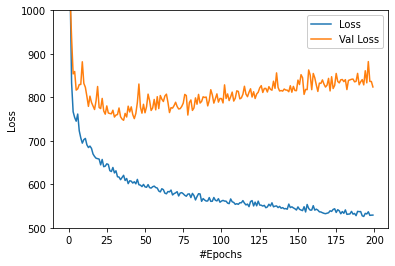

In [ ]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
xc         = range(200)

#fig.suptitle('Training Loss')
plt.xlabel('#Epochs')
plt.ylabel('Loss')

#plt.figure()
plt.plot(xc, train_loss, label='Loss')
plt.plot(xc, val_loss, label='Val Loss')
plt.ylim((500,1000))
plt.legend(framealpha=1, frameon=True);


(24, 128, 128, 3)


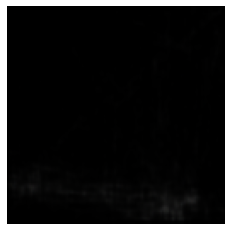

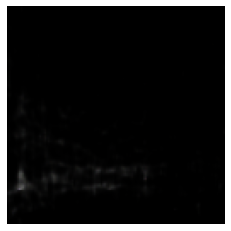

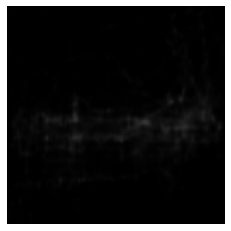

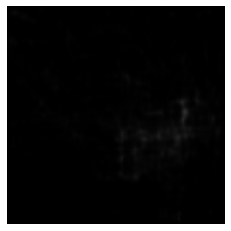

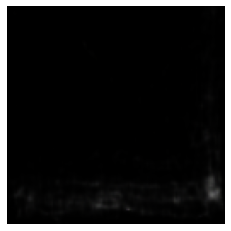

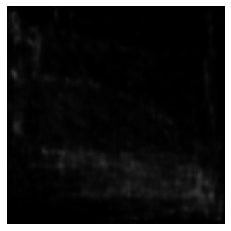

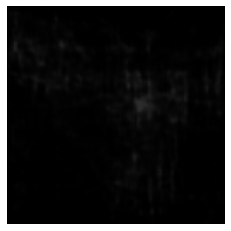

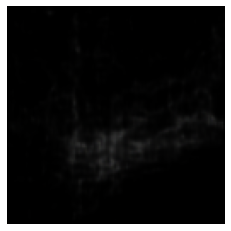

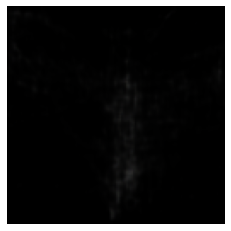

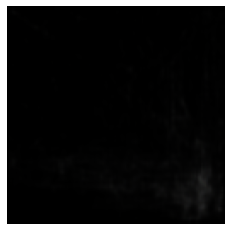

In [ ]:
import cv2
OUTPUT_FOLDER_NEG='/content/drive/My Drive/output2/neg/'

z_mean, _, _ = encoder.predict(x_test)
decoded_imgs = decoder.predict(z_mean)

#print(z_mean)
print(decoded_imgs.shape)

n = 10
for i in range(10): 
	plt.gray()
	cv2.imwrite(OUTPUT_FOLDER_NEG + 'image'+str(i)+'.jpg', decoded_imgs[i], [cv2.IMWRITE_JPEG_QUALITY, 100])
	plt.axis('off')
	spec = plt.imshow(decoded_imgs[i].reshape(128, 128,3))
	plt.savefig('spec',bbox_inches='tight',transparent=True, pad_inches=0)
	plt.savefig(OUTPUT_FOLDER_NEG + 'plot'+str(i)+'.jpg',bbox_inches='tight', pad_inches=0)
	plt.show()